# Self-supervised scene classification
Note that a lot of this code has been based on the practical session of the course.

In [16]:
import torch
from torchvision import datasets, transforms, models
import torchvision
from torch.optim import Adam, SGD

from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

import os
import time

import pandas as pd
import numpy as np

from PIL import Image

from torch import nn, optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix

In [17]:
## settings
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 15
BATCH_SIZE = 15
NUM_EPOCHS = 32
LEARNING_RATE = 0.0001
OPTIMIZER = "Adam"

## 2 15-Scene Dataset
The dataset contains 15 categories of different scenes [1]. The categories are office,
kitchen, living room, bedroom, store, industrial, tall building, inside cite, street, highway,
coast, open country, mountain, forest, and suburb. The dataset has been divided into
two parts train and test. Each part has equally 15 different classes of scenes. The train
set is used during the training process in order to ”teach” the model how to classify images. The validation set is used to evaluate the model after each epoch, it is not seen
by the model during training. You will find the dataset in the BlackBoard platform, located at UA 2500WETANN: Artificial Neural Material > Practical Session > datasets >
self-supervised scene classification Project.

In [18]:
def get_scene_data_loader(batch_size):
    """
    Returns a train and validation data loader for the 15 scene dataset.

    :param batch_size: the batch size to use

    :return: the train and validation data loader
    """

    # Transformations to be applied on the images
    transform = transforms.Compose([
        transforms.Resize(INPUT_SHAPE[:2]),
        transforms.ToTensor()
    ])

    # Load the dataset
    # data_folder = '15SceneData_small'
    data_folder = '15SceneData'

    train_folder = os.path.join(data_folder, 'train')
    val_folder = os.path.join(data_folder, 'validation')

    train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_folder, transform=transform)

    # Create the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # get the labels
    global LABELS
    LABELS = train_dataset.classes

    # for testing only if no 15SceneData_small folder
    # train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, sampler=torch.utils.data.SubsetRandomSampler(range(0, int(len(train_dataset) * 0.1))))
    # val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2, sampler=torch.utils.data.SubsetRandomSampler(range(0, int(len(train_dataset) * 0.1))))

    return train_loader, val_loader

In [19]:
train_loader, val_loader = get_scene_data_loader(BATCH_SIZE)

In [20]:
def visualize_3x3_images(images, labels, class_names=None):
    """
    Visualizes a 3x3 plot of images with their corresponding labels.

    :param images: the images to plot
    :param labels: the labels to plot
    """
    if class_names is None:
        class_names = LABELS

    fig, axes = plt.subplots(nrows=3, ncols=3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(f"{class_names[labels[i]]}")
        ax.axis('off')

    plt.show()

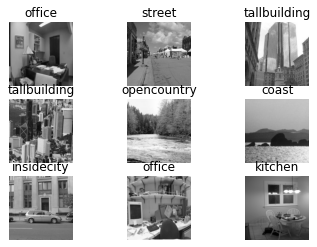

In [21]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))
visualize_3x3_images(images, labels)

## 3 Classification schemes
In this section, the fully-supervised and self-supervised methods that should be implemented in this assignment are explained in more detail.

In [22]:
def get_n_fc_layers(model):
    """
    Returns the number of fully connected layers of a model.

    :param model: the model to get the number of fully connected layers from

    :return: the number of fully connected layers
    """
    n_fc_layers = 0
    for layer in model.children():
        if isinstance(layer, torch.nn.Linear):
            n_fc_layers += 1

    return n_fc_layers

In [23]:
class TrainLogger:
    def __init__(self, train_config, train_loader, val_loader, model, descr=""):
        self.train_config = train_config

        self.train_loss_list_per_epoch = []
        self.train_loss_list_per_itr = []
        self.val_loss_list = []
        self.val_accuracy_per_epoch = []
        self.time_s = time.time()

        time_str = time.strftime("%Y%m%d_%H%M%S")
        self.identifier = descr + "_" + time_str

        self.output_folder = os.path.join("outputs", self.identifier)
        os.makedirs(self.output_folder, exist_ok=True)

        self.time_e = None

        self.train_size = len(train_loader.dataset)
        self.val_size = len(val_loader.dataset)

        self.batch_size = train_loader.batch_size

        self.fc_layers = get_n_fc_layers(model)

    def notify_itr_end(self, itr, train_loss):
        if itr % 10 == 0:
            self.train_loss_list_per_itr.append(train_loss.item())

    def notify_epoch_end(self, epoch, model, eval_loss, eval_acc):
        self.train_loss_list_per_epoch.append(np.mean(self.train_loss_list_per_itr))
        self.train_loss_list_per_itr = []

        self.val_loss_list.append(eval_loss)
        self.val_accuracy_per_epoch.append(eval_acc)

        self.save_model(model, epoch)

        print(f'Epoch {epoch} finished. Train loss: {self.train_loss_list_per_epoch[-1]}, Val loss: {eval_loss}, Val accuracy: {eval_acc}')

    def get_train_duration(self):
        """Returns the duration of the training in minutes"""
        return (self.time_e - self.time_s) / 60

    def notify_train_end(self, model):
        self.time_e = time.time()
        self.save_log_info()
        self.save_model(model)
        self.plot_all()

    def plot_all(self):
        plt.plot(np.arange(len(self.train_loss_list_per_epoch)), self.train_loss_list_per_epoch, color='blue',
                 label='Train')
        plt.plot(np.arange(len(self.val_loss_list)), self.val_loss_list, color='red', label='Validation')
        plt.legend()
        plt.title('Train and Validation Loss')
        plt.savefig(f'{self.output_folder}/train_val_loss.png')

        plt.cla()

        plt.plot(np.arange(len(self.val_accuracy_per_epoch)), self.val_accuracy_per_epoch, color='green',
                 label='Validation')
        plt.title('Validation Accuracy')
        plt.savefig(f'{self.output_folder}/validation_accuracy.png')

    def get_info_table(self):
        table = ""

        table_values = {
            "Input image size": self.train_config.input_size,
            "Learning rate": self.train_config.lr,
            "Optimizer": self.train_config.optimizer,
            "Batch size": self.batch_size,
            "Number of epochs": self.train_config.num_epochs,
            "Number of fully-connected layers": self.fc_layers
        }

        for key, value in table_values.items():
            table += f"{key}\t{value}\n"

        return table

    def save_model(self, model, epoch=None):
        if epoch is not None:
            filename = f'{self.output_folder}/model_epoch_{epoch}.pt'
        else:
            filename = f'{self.output_folder}/model.pt'

        torch.save(model.state_dict(), filename)

    def save_log_info(self):
        filename = f'{self.output_folder}/log.txt'
        with open(filename, 'w') as f:
            f.write(f"Training time in Mins : {self.get_train_duration()}\n")

            f.write(self.get_info_table())
            f.write('\n')

            f.write('Train config:\n')
            f.write(str(self.train_config.__dict__))
            f.write('\n')

            f.write('Train loss values per iteration\n')
            f.write(str(self.train_loss_list_per_epoch))
            f.write('\n')

            f.write('Validation loss values per iteration\n')
            f.write(str(self.val_loss_list))
            f.write('\n')

            f.write('Validation accuracy values per iteration\n')
            f.write(str(self.val_accuracy_per_epoch))
            f.write('\n')

        # also write numbers to excel file (different sheets, each sheet contains the epoch number (index) and the value)
        filename = f'{self.output_folder}/log.xlsx'

        df_train_loss_list_per_epoch = pd.DataFrame(self.train_loss_list_per_epoch)
        df_val_loss_list = pd.DataFrame(self.val_loss_list)
        df_val_accuracy_per_epoch = pd.DataFrame(self.val_accuracy_per_epoch)

        writer = pd.ExcelWriter(filename, engine='xlsxwriter')

        df_train_loss_list_per_epoch.to_excel(writer, sheet_name='train_loss')
        df_val_loss_list.to_excel(writer, sheet_name='val_loss')
        df_val_accuracy_per_epoch.to_excel(writer, sheet_name='val_accuracy')

        print(f"Saved log info to {filename}")

In [24]:
class TrainConfig:
    def __init__(self, lr=LEARNING_RATE, num_epochs=NUM_EPOCHS, criterion=None, optimizer=OPTIMIZER,
                 input_size=INPUT_SHAPE):
        self.lr = lr
        self.num_epochs = num_epochs
        self.criterion = criterion if criterion else torch.nn.CrossEntropyLoss()
        self.optimizer = optimizer

        if input_size != INPUT_SHAPE:
            print(
                f"Warning: different input size from config not supported (since this is the train config and not loader config)")

        self.input_size = input_size

    def get_optimizer(self, model):
        if self.optimizer == "Adam":
            return Adam(model.parameters(), lr=self.lr)
        elif self.optimizer == "SGD":
            return SGD(model.parameters(), lr=self.lr)
        else:
            raise NotImplementedError("Optimizer not implemented")

In [25]:
def evalution(model, validation_loader, criterion, pretext_task=None):
    val_loss = []

    real_label = None
    pred_label = None
    for inputs, labels in validation_loader:

        if pretext_task is not None:
            inputs, labels = pretext_task(inputs, labels)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss.append(loss.item())

        _, preds = torch.max(outputs, 1)
        if real_label is None:
            real_label = labels.data
            pred_label = preds
        else:
            real_label = torch.cat((real_label, labels.data), dim=0)
            pred_label = torch.cat((pred_label, preds), dim=0)

        del inputs
        del labels

    real_label = real_label.detach().cpu().numpy()
    pred_label = pred_label.detach().cpu().numpy()

    eval_acc = accuracy_score(real_label, pred_label)
    # report = classification_report(real_label, pred_label)
    # eval_acc = float(report.split('accuracy')[1].split(' ')[27])

    return np.mean(val_loss), eval_acc

In [26]:
def train(model, train_loader, validation_loader, train_config, pretext_task=None, log_descr=None):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = train_config.get_optimizer(model)

    log = TrainLogger(train_config=train_config,
                      train_loader=train_loader,
                      val_loader=validation_loader,
                      model=model,
                      descr=log_descr)

    for epoch in range(train_config.num_epochs):
        for itr, (inputs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):

            if pretext_task is not None:
                # change the inputs and labels to the pretext task
                inputs, labels = pretext_task(inputs, labels)

            model.train(True)

            # clearing old gradients from the last step
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # computing the derivative of the loss w.r.t. the parameters
            loss.backward()
            # optimizer takes a step in updating parameters based on the gradients of the parameters.
            optimizer.step()

            log.notify_itr_end(itr, train_loss=loss)

        # Evaluate model for each update iteration
        model.eval()
        with torch.no_grad():
            eval_loss, eval_acc = evalution(model, validation_loader, criterion, pretext_task)

        log.notify_epoch_end(epoch, model=model, eval_loss=eval_loss, eval_acc=eval_acc)

    log.notify_train_end(model)

    return model, log

In [27]:
# load the model
def load_model(path, num_classes=NUM_CLASSES, evaluation_mode=True):
    model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

    classifier_in = model_efficient_b0.classifier[-1].in_features
    model_efficient_b0.classifier[-1] = torch.nn.Linear(in_features=classifier_in, out_features=num_classes)

    model_efficient_b0.load_state_dict(torch.load(path))

    if evaluation_mode:
        model_efficient_b0.eval()

    return model_efficient_b0

In [28]:
def make_trainable(model, train_features: bool, train_classifier: bool):
    for params in model.features.parameters():
        params.requires_grad = train_features

    for params in model.classifier.parameters():
        params.requires_grad = train_classifier

In [29]:
def modify_classification_head(model, num_classes):
    classifier_in = model.classifier[-1].in_features
    model.classifier[-1] = torch.nn.Linear(in_features=classifier_in, out_features=num_classes)
    return model

## 3.1 Supervised learning scheme
In this section, you should fine-tune a convolutional neural network architecture, pretrained on the ImageNet [2] dataset, on the 15 scene dataset. In this assignment you will
use a pre-trained EfficientNet-B0 architecture. Following the exercise session on Transfer
Learning, you should make all layers in feature extraction and classifier parts of the model
trainable. The bellow address provides you with the scheme of the architecture of the
EfficientNet-B0.
https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd

In [ ]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

# Number of classes is different, so change the last classification layer
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

train_config = TrainConfig()

model_efficient_b0, train_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                      log_descr="supervised")

torch.save(model_efficient_b0.state_dict(), 'model_efficient_b0_supervised.pth')

100%|██████████| 100/100 [06:28<00:00,  3.89s/it]


## 3.2 Self-supervised learning scheme

### 3.2.1 Pretext Task 1: Rotation Classification

In [ ]:
class RotationPretext:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, inputs, labels):
        """"
        :param inputs: batch of images
        :param labels: batch of labels
        :return: rotated images and labels corresponding to the rotation angle
        """
        for i in range(len(inputs)):
            angle_index = np.random.randint(len(self.angles))
            angle = self.angles[angle_index]
            inputs[i] = transforms.functional.rotate(inputs[i], angle)
            labels[i] = angle_index
        return inputs, labels

In [ ]:
# test the rotation pretext task
images, labels = next(iter(train_loader))

angles = [0, 90, 180, 270]
rotation_pretext = RotationPretext([0, 90, 180, 270])
images, labels = rotation_pretext(images, labels)

visualize_3x3_images(images, labels, class_names=angles)

In [ ]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
angles = [0, 90, 180, 270]
pretext_task = RotationPretext(angles=angles)
modify_classification_head(model_efficient_b0, num_classes=len(angles))

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig()

model_efficient_b0, pretext_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                        pretext_task=pretext_task, log_descr="pretext_only_rotation")

# Actual scene classification task
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(model_efficient_b0, train_features=False, train_classifier=True)

train_config = TrainConfig()

model_efficient_b0, train_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                      log_descr="pretext_rotation")

### 3.2.2 Pretext Task 2: Perturbation Classification

In [ ]:
class PerturbationPretext:
    def __init__(self, perbutation_colors=[0, 255]):
        self.perbutation_colors = perbutation_colors

    def __call__(self, inputs, labels):
        """"
        :param inputs: batch of images
        :param labels: batch of labels
        :return: perturbed images and labels corresponding the perbutation color
        """
        for i in range(len(inputs)):
            perturbation_index = np.random.randint(len(self.perbutation_colors))
            perturbation_color = self.perbutation_colors[perturbation_index]
            inputs[i] = self._apply_perbutation(inputs[i], perturbation_color)
            labels[i] = perturbation_index
        return inputs, labels

    def _apply_perbutation(self, input, color):
        """"
        To do the perturbation you need to define a random square region W with a shape 10 × 10 on an image. Then, the pixels within the window are set to given color
        """
        region_size = 10
        x = np.random.randint(0, input.shape[1] - region_size)
        y = np.random.randint(0, input.shape[2] - region_size)
        input[:, x:x + region_size, y:y + region_size] = color
        return input

In [ ]:
# test the perturbation pretext task
images, labels = next(iter(train_loader))

perturbation_pretext = PerturbationPretext()
images, labels = perturbation_pretext(images, labels)

visualize_3x3_images(images, labels, class_names=["black", "white"])

In [ ]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
modify_classification_head(model_efficient_b0, num_classes=2)

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig()

pretext_task = PerturbationPretext()

model_efficient_b0, pretext_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                        pretext_task=pretext_task, log_descr="pretext_only_perturbation")

# Actual scene classification task
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(model_efficient_b0, train_features=False, train_classifier=True)

model_efficient_b0, train_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                      log_descr="pretext_perturbation")

# Model explanation and interpretation
In this section, you are requested to explain and interpret the models trained following the
fully-supervised and self-supervised procedures.

In [ ]:
MODEL_SAVES = {
    "supervised": "model_efficient_b0_supervised.pth",
    # "pretext_rotation": "",
    "pretext_perturbation": "model_efficient_b0_pretext_perturbation.pth"
}


## Explanation

In [29]:
from torchcam.methods import ScoreCAM


def get_explanation(model, image, layer, label=None):
    image = image.unsqueeze(0)

    cam = ScoreCAM(model, target_layer=layer)
    with torch.no_grad():
        out = model(image)

    label_idx = out.argmax()

    if label is None:
        label = label_idx

    if not label_idx == label:
        print("Warning: model prediction is not equal to the actual label")

    label_int = label_idx.item()
    explanation = cam(class_idx=label_int)
    return explanation


def get_last_conv_layer(sequence):
    # warning: this function doesn't work for nested sequences
    for layer in reversed(sequence):
        if isinstance(layer, torch.nn.Conv2d):
            return layer
    raise Exception("No convolutional layer found")


def explain_predictions(model, images):
    """
    :param model: model to explain (efficientnet modification)
    :param images: images to explain (batch, already as tensor) and labels
    """
    explanations_lower_layer_b1 = []
    explanations_lower_layer_b2 = []
    explanations_higher_layer = []

    # get the last convolutional layer in the EfficientNet-B0
    last_conv_layer = model.classifier[1]

    # get the last convolutional layer in the first and second block of the EfficientNet-B0 architecture
    block0 = model.features[0]
    block1 = model.features[1]
    first_block = block0[0]
    second_block = block1[0].block[2]

    for image, label in zip(images[0], images[1]):
        # get the explanation for the higher layer
        explanation_higher_layer = get_explanation(model, image, last_conv_layer, label)
        explanations_higher_layer.append(explanation_higher_layer)

        # get the explanation for the lower layer
        explanation_lower_layer_b1 = get_explanation(model, image, first_block, label)
        explanations_lower_layer_b1.append(explanation_lower_layer_b1)

        explanation_lower_layer_b2 = get_explanation(model, image, second_block, label)
        explanations_lower_layer_b2.append(explanation_lower_layer_b2)

        explanations = [(explanations_lower_layer_b1, "Conv b1"), (explanations_lower_layer_b2, "Conv b2"),
                        (explanations_higher_layer, "Last conv")]

        num_expl = len(explanations)
        fig, ax = plt.subplots(1, num_expl, figsize=(5 * num_expl, 5))
        ax[0].imshow(image.permute(1, 2, 0))
        ax[0].set_title("Original image")

        for i, (expl, descr) in enumerate(explanations):
            ax[i + 1].imshow(image.permute(1, 2, 0))
            ax[i + 1].imshow(expl.squeeze().cpu(), alpha=0.5, cmap="jet")
            ax[i + 1].set_title(descr)

        plt.show()

In [27]:
def get_correctly_predicted_images(model, loader, num_images=8):
    """
    :param model: model to explain (efficientnet modification)
    :param loader: loader to get images from
    :param num_images: number of images to get
    :return: list of images and labels
    """
    images = []
    labels = []
    for image_batch, label_batch in loader:
        for image, label in zip(image_batch, label_batch):
            image = image.unsqueeze(0)
            prediction = model(image)
            prediction = torch.argmax(prediction, dim=1)
            if prediction == label:
                images.append(image)
                labels.append(label)
            if len(images) == num_images:
                break
        if len(images) == num_images:
            break
    return images, labels

In [124]:
model = load_model(MODEL_SAVES["supervised"])
images_to_explain = get_correctly_predicted_images(model, val_loader, num_images=1)
explain_predictions(model, images_to_explain)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: _get_weights() got an unexpected keyword argument 'dimensions'

In [ ]:
model = load_model(MODEL_SAVES["pretext_rotation"])
images_to_explain = get_correctly_predicted_images(model, val_loader)
explain_predictions(model, images_to_explain)

In [ ]:
model = load_model(MODEL_SAVES["pretext_perturbation"])
images_to_explain = get_correctly_predicted_images(model, val_loader)
explain_predictions(model, images_to_explain)

In [30]:
model = models.efficientnet_b0(weights="IMAGENET1K_V1")
batch = next(iter(val_loader))
explain_predictions(model, batch)

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [] and output size of torch.Size([224, 224]). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.


## Interpretation
For the interpretation part, you should utilize the model inversion method proposed
in [3]. This model inversion technique is part of the last exercise session.

In [ ]:
from RegularizedUnitSpecificImageGeneration import RegularizedClassSpecificImageGeneration

# select 5 classes randomly
target_classes = np.random.choice(LABELS, 5, replace=False)


def get_interpretation(model, output_dir):
    for target_class in target_classes:
        print(f"Generating interpretation for class {target_class}")
        target_class_idx = LABELS.index(target_class)
        csig = RegularizedClassSpecificImageGeneration(model, target_class_idx, output_dir=output_dir)
        csig.generate(iterations=1000)

In [ ]:
model = load_model(MODEL_SAVES["supervised"])
get_interpretation(model, output_dir="outputs/supervised/intepretation")

In [ ]:
model = load_model(MODEL_SAVES["pretext_rotation"])
get_interpretation(model, output_dir="outputs/pretext_rotation/intepretation")

In [ ]:
model = load_model(MODEL_SAVES["pretext_perturbation"])
get_interpretation(model, output_dir="outputs/pretext_perturbation/intepretation")

In [25]:
model_efficient_b0 = models.efficientnet_b0(weights='IMAGENET1K_V1')
get_interpretation(model_efficient_b0, output_dir="outputs/efficient_b0")

Generating interpretation for class mountain
Iteration: 111 Loss -12.79
Iteration: 222 Loss -14.29
Iteration: 333 Loss -19.21
Iteration: 444 Loss -20.64
Iteration: 555 Loss -17.21
Iteration: 666 Loss -17.79
Iteration: 777 Loss -19.60
Iteration: 888 Loss -24.74


# Evaluation

In [ ]:
def evaluation_report(model, loader):
    """
    :param model: the model to be evaluated
    :param loader: the loader to be used for evaluation
    :return: the classification report and the confusion matrix
    """
    y_true = []
    y_pred = []

    for images, labels in loader:
        y_true.extend(labels.numpy())
        y_pred.extend(model(images).argmax(dim=1).numpy())

    return classification_report(y_true, y_pred, target_names=LABELS), confusion_matrix(y_true, y_pred)

In [ ]:
for model_name in MODEL_SAVES:
    model = load_model(MODEL_SAVES[model_name])
    report, confusion = evaluation_report(model, val_loader)
    print(f"Model: {model_name}")
    print(report)
    print(confusion)
    print("\n\n")

In [ ]:



def explain_predictions(model, val_batch):
    """
    Takesimages from the validation set and generates a Score-CAM explanation for each of them.
    :param model: the model to be explained
    :param val_batch: the validation set images and labels to explain
    """

    explanations = []

    images = val_batch[0]
    labels = val_batch[1]

    for image, label in zip(images, labels):
        # get the explanation for the final layr
        target_layer = model._modules.get('classifier')  # tODO: dit of model.classifier[-1]
        cam_extractor = ScoreCAM(model=model, target_layer=target_layer)

        # get the explanation for the image
        explanation = cam_extractor(image, target_category=label)
        explanations.append(explanation)

        # create plots, where each row contais the original image, the heatmap and the heatmap overlayed on the original image
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image.permute(1, 2, 0))
        ax[0].set_title("Original image")

        ax[1].imshow(explanation.squeeze().permute(1, 2, 0))
        ax[1].set_title("Heatmap")

        ax[2].imshow(image.permute(1, 2, 0))
        ax[2].imshow(explanation.squeeze().permute(1, 2, 0), alpha=0.5)
        ax[2].set_title("Heatmap overlayed on the original image")


images_to_explain = next(iter(val_loader))[0][:3]